<a href="https://colab.research.google.com/github/zicomarchellino7/FishGenius/blob/main/Machine%20Learning/FishGenius%20Fish%20Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-family:verdana;"> <center>Fish Classification using Deep Convolutional Neural Networks and Transfer Learning</center> </h1>


***



# 🏗️Import Necessary Libraries

In [ ]:
!pip install keras.preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 609.9 kB/s eta 0:00:00


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# 🤙Create helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-06-03 07:31:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-03 07:31:08 (55.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and transform data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
from google.colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Walk through each directory
dataset = "/content/drive/MyDrive/Dataset_FishGenius"
walk_through_dir(dataset)

There are 8 directories and 0 images in '/content/drive/MyDrive/Dataset_FishGenius'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Tuna'.
There are 0 directories and 93 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Bawal'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Nila'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Lele'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Bandeng'.
There are 0 directories and 54 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Patin'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Salmon'.
There are 0 directories and 46 images in '/content/drive/MyDrive/Dataset_FishGenius/Ikan Gurame'.


# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath         Label
0    /content/drive/MyDrive/Dataset_FishGenius/Ikan...    Ikan Bawal
1    /content/drive/MyDrive/Dataset_FishGenius/Ikan...  Ikan Bandeng
2    /content/drive/MyDrive/Dataset_FishGenius/Ikan...     Ikan Tuna
3    /content/drive/MyDrive/Dataset_FishGenius/Ikan...     Ikan Tuna
4    /content/drive/MyDrive/Dataset_FishGenius/Ikan...     Ikan Tuna
..                                                 ...           ...
783  /content/drive/MyDrive/Dataset_FishGenius/Ikan...   Ikan Salmon
784  /content/drive/MyDrive/Dataset_FishGenius/Ikan...   Ikan Salmon
785  /content/drive/MyDrive/Dataset_FishGenius/Ikan...   Ikan Gurame
786  /content/drive/MyDrive/Dataset_FishGenius/Ikan...   Ikan Gurame
787  /content/drive/MyDrive/Dataset_FishGenius/Ikan...   Ikan Gurame

[788 rows x 2 columns]

# 🔭Visualizing images from the dataset

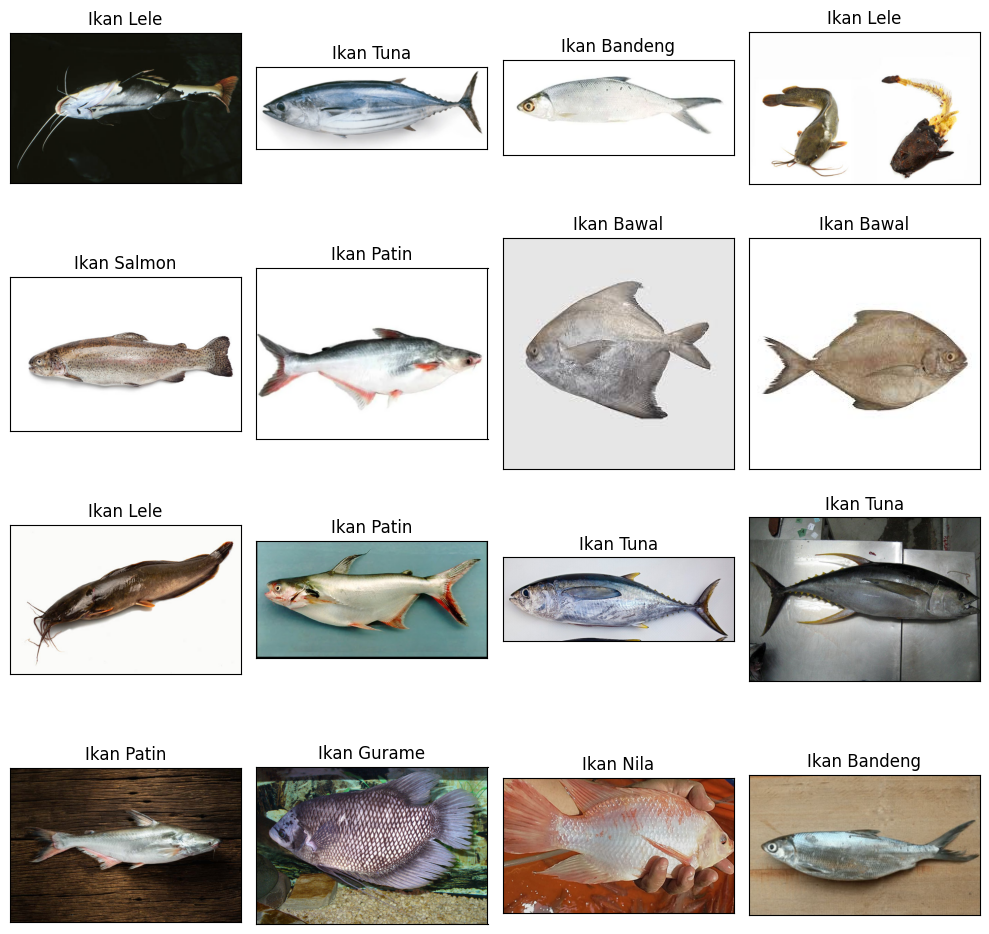

In [ ]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 🧮Computing Error Rate Analysis

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

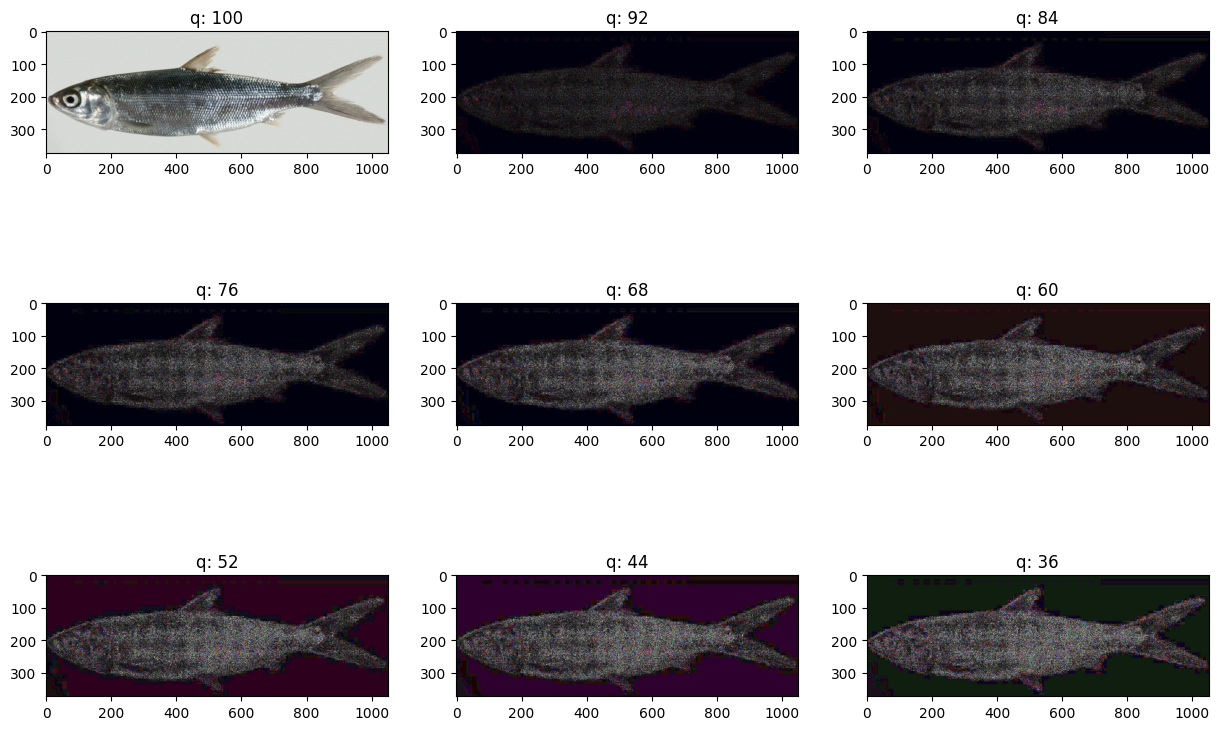

In [ ]:
# View random sample from the dataset
p = random_sample('/content/drive/MyDrive/Dataset_FishGenius/Ikan Bandeng')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# 📝Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 504 validated image filenames belonging to 8 classes.
Found 126 validated image filenames belonging to 8 classes.
Found 158 validated image filenames belonging to 8 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name="data_augmentation")

# 🤹Training the model
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (300, 300, 3)

**Output layer** : 10



In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "/content/drive/MyDrive/fish_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Train the model

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs= 160,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("/content/drive/MyDrive/training_logs",
                                    "/content/drive/MyDrive/fish_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: /content/drive/MyDrive/training_logs//content/drive/MyDrive/fish_classification/20240603-073154
Epoch 1/160
16/16 [==============================] - ETA: 0s - loss: 2.4103 - accuracy: 0.1151

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 [==============================] - 145s 8s/step - loss: 2.4103 - accuracy: 0.1151 - val_loss: 2.2431 - val_accuracy: 0.2143
Epoch 2/160
16/16 [==============================] - 30s 2s/step - loss: 2.3393 - accuracy: 0.1131 - val_loss: 2.1657 - val_accuracy: 0.2222
Epoch 3/160
16/16 [==============================] - 26s 2s/step - loss: 2.2559 - accuracy: 0.1567 - val_loss: 2.0991 - val_accuracy: 0.2619
Epoch 4/160
16/16 [==============================] - 24s 1s/step - loss: 2.2148 - accuracy: 0.1528 - val_loss: 2.0361 - val_accuracy: 0.2619
Epoch 5/160
16/16 [==============================] - 31s 2s/step - loss: 2.0939 - accuracy: 0.2143 - val_loss: 1.9780 - val_accuracy: 0.2857
Epoch 6/160
16/16 [==============================] - 25s 2s/step - loss: 2.1022 - accuracy: 0.2143 - val_loss: 1.9257 - val_accuracy: 0.3095
Epoch 7/160
16/16 [==============================] - 27s 2s/step - loss: 1.9775 - accuracy: 0.2738 - val_loss: 1.8748 - val_accuracy: 0.3333
Epoch 8/160
16/16 [=====

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ✔️Model Evaluation
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4> <center>$P=TP/(TP+FP)$</center></h4>

<h3>Recall(R): </h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>
<h4><center>$R=TP/(TP+FN)$</center></h4>

<h3>F1 score(F1): </h3>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>
<h4><center>$F1=2 * (TP * FP)/(TP+FP)$</center></h4>




In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.18180
Test Accuracy: 96.20%


# 📉Visualizing loss curves

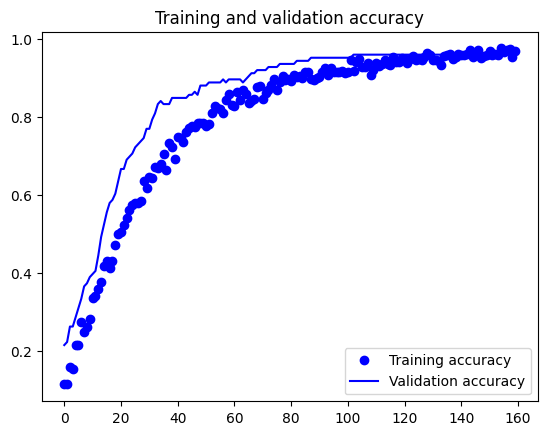

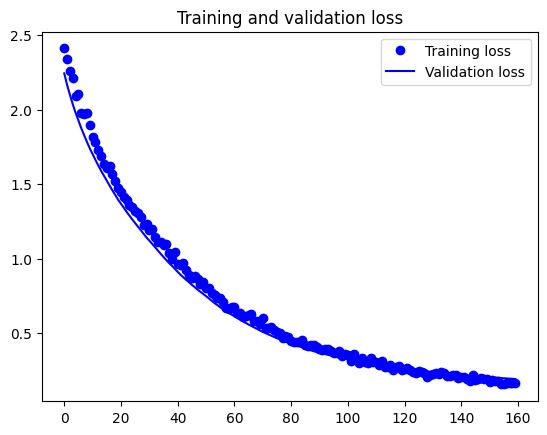

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Making predictions on the test data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

5/5 [==============================] - 8s 1s/step
The first 5 predictions: ['Ikan Tuna', 'Ikan Bandeng', 'Ikan Bandeng', 'Ikan Tuna', 'Ikan Lele']


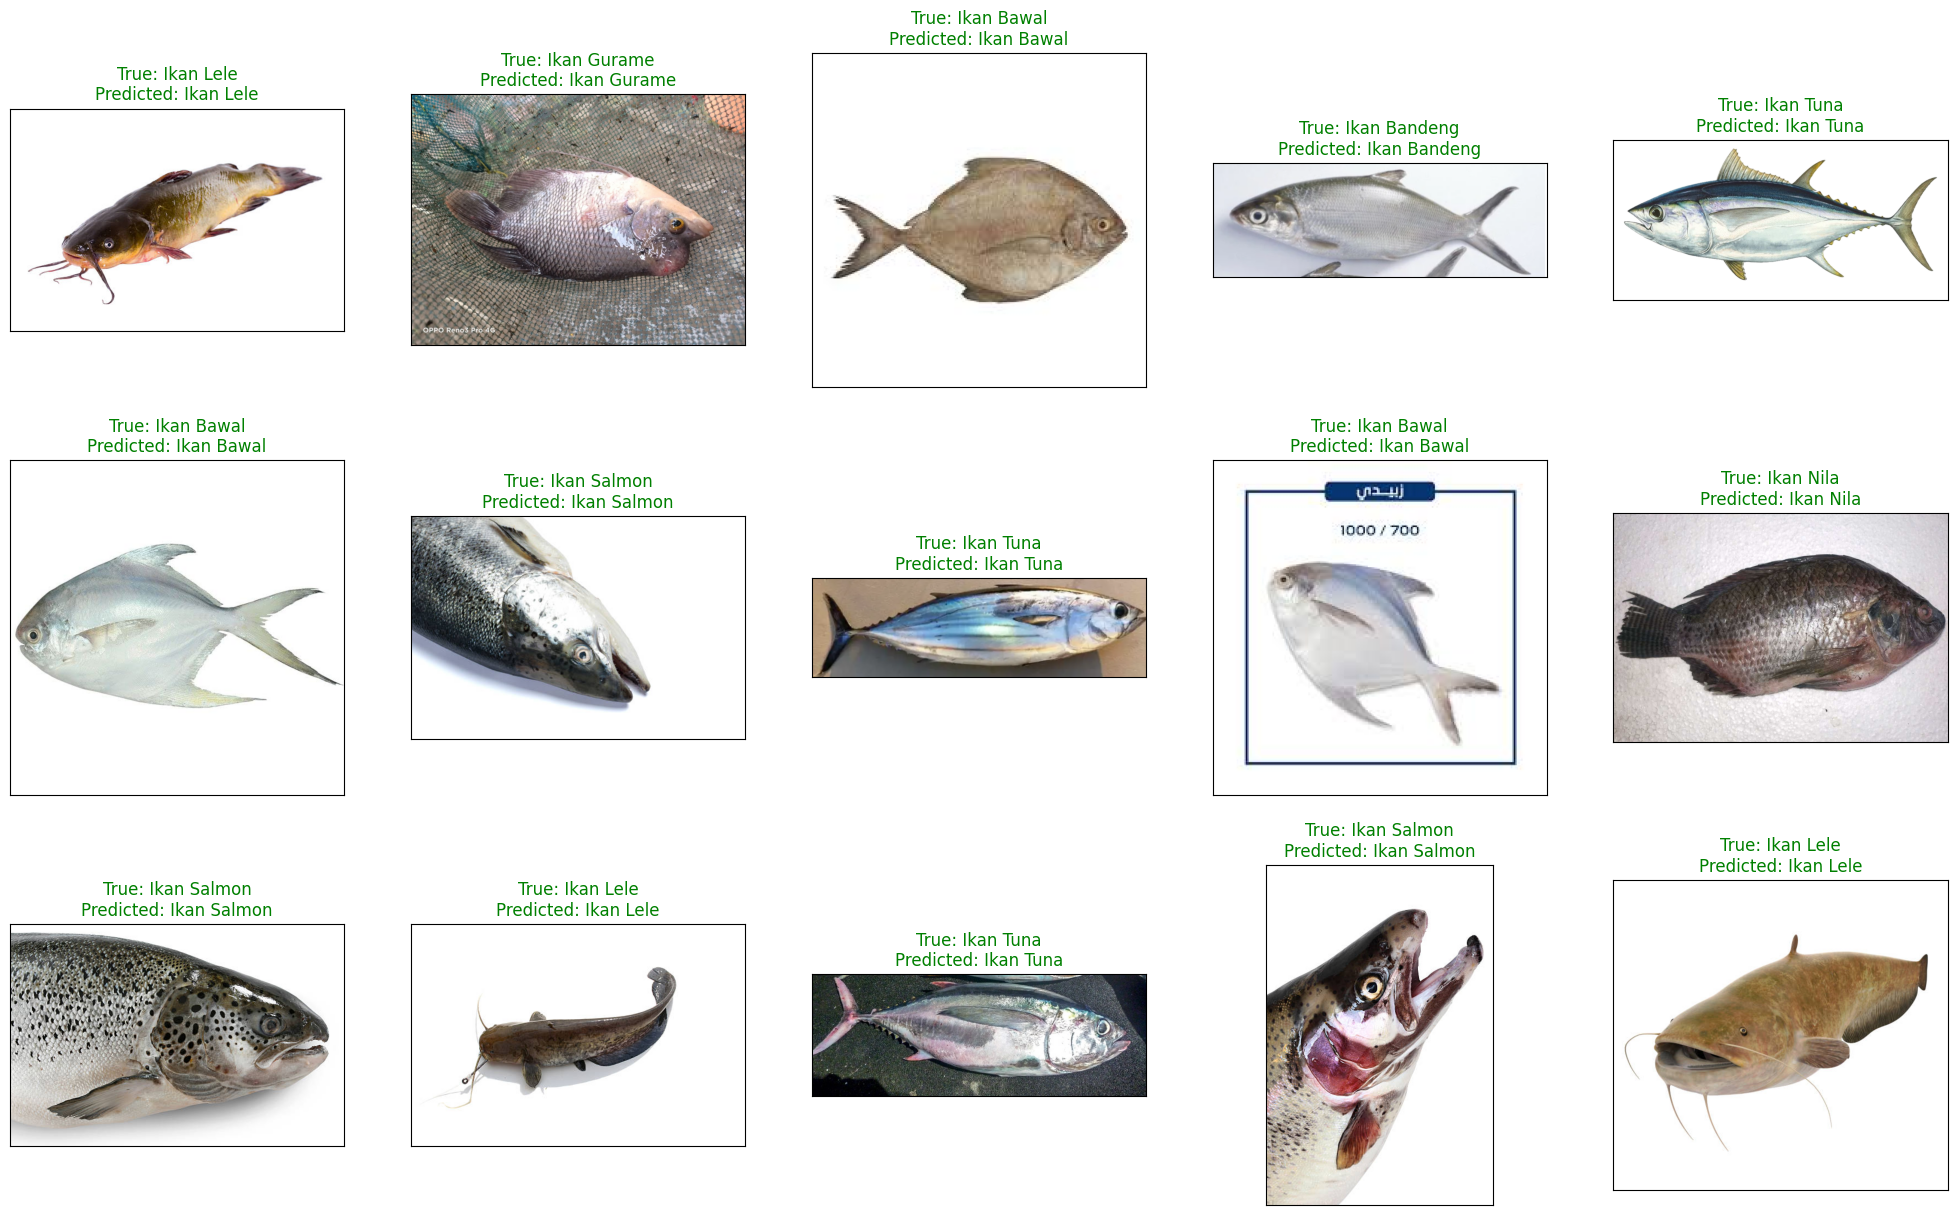

<Figure size 640x480 with 0 Axes>

In [ ]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the classification reports and confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

Ikan Bandeng       0.86      1.00      0.93        25
  Ikan Bawal       1.00      0.96      0.98        25
 Ikan Gurame       1.00      0.90      0.95        10
   Ikan Lele       1.00      1.00      1.00        16
   Ikan Nila       0.95      0.95      0.95        19
  Ikan Patin       0.94      1.00      0.97        15
 Ikan Salmon       1.00      0.85      0.92        20
   Ikan Tuna       1.00      1.00      1.00        28

    accuracy                           0.96       158
   macro avg       0.97      0.96      0.96       158
weighted avg       0.97      0.96      0.96       158



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Ikan Bandeng   0.862069  1.000000  0.925926   25.000000
Ikan Bawal     1.000000  0.960000  0.979592   25.000000
Ikan Gurame    1.000000  0.900000  0.947368   10.000000
Ikan Lele      1.000000  1.000000  1.000000   16.000000
Ikan Nila      0.947368  0.947368  0.947368   19.000000
Ikan Patin     0.937500  1.000000  0.967742   15.000000
Ikan Salmon    1.000000  0.850000  0.918919   20.000000
Ikan Tuna      1.000000  1.000000  1.000000   28.000000
accuracy       0.962025  0.962025  0.962025    0.962025
macro avg      0.968367  0.957171  0.960864  158.000000
weighted avg   0.965913  0.962025  0.962064  158.000000

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=10, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


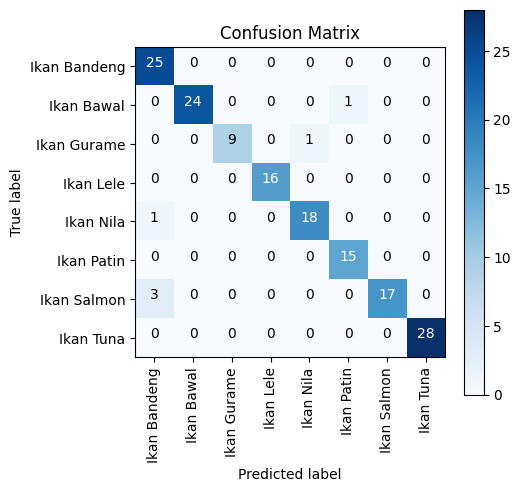

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# ☀️Grad-Cam Visualization

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (300,300)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-29-2a1a4acc06bb>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


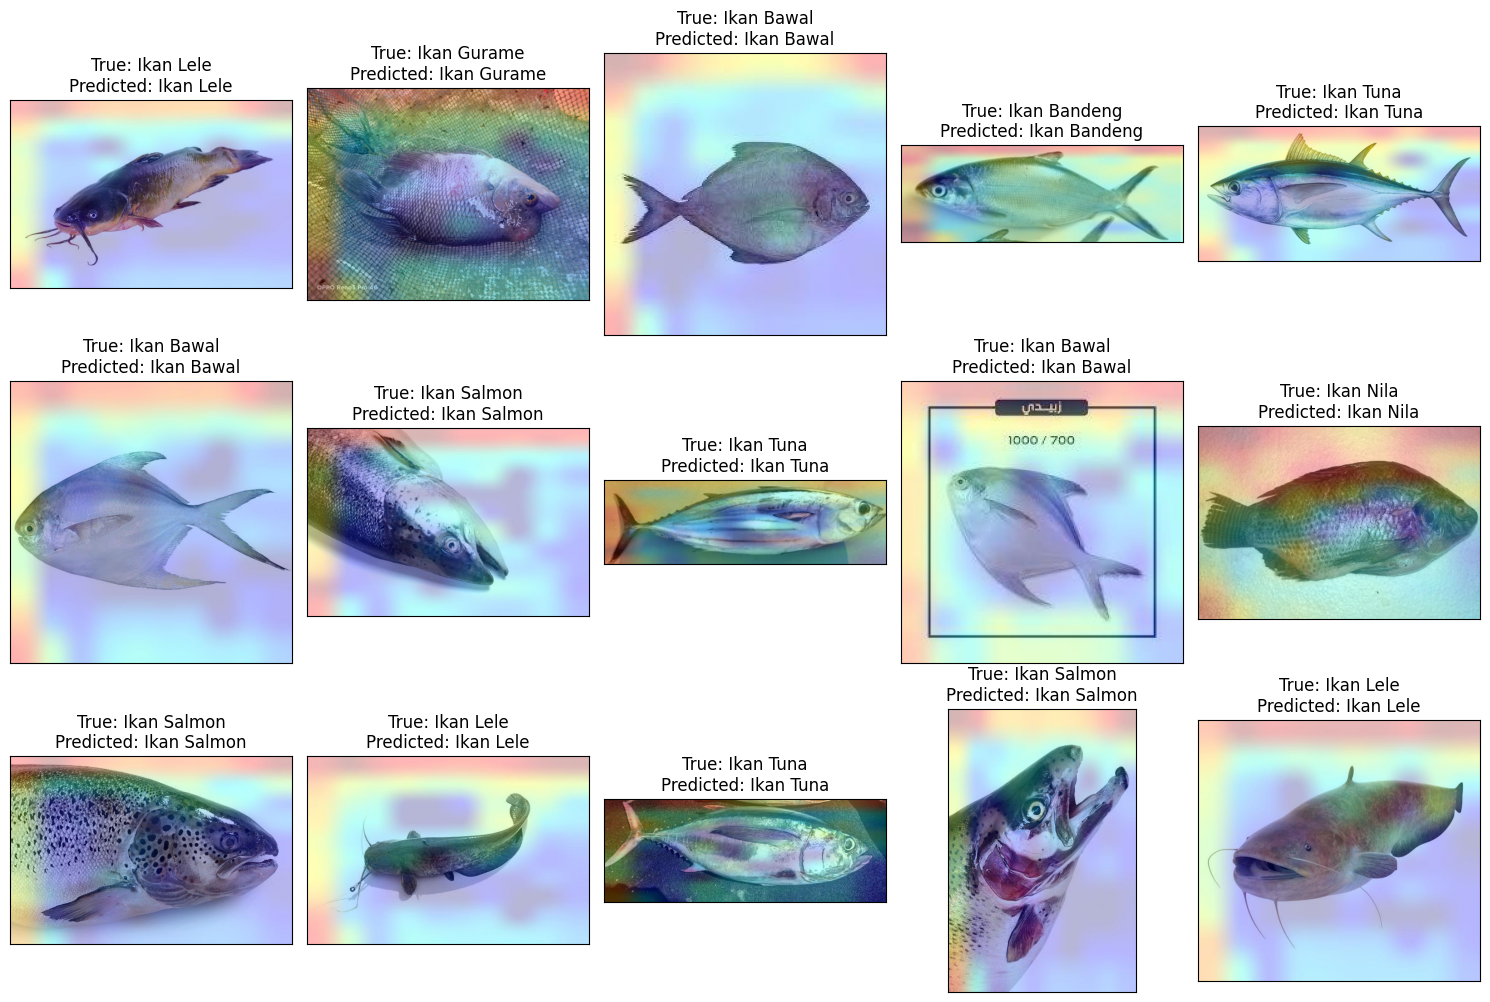

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/model.pb')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/model.pb") # path to the SavedModel directory
tflite_model = converter.convert()

In [ ]:
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
  f.write(tflite_model)